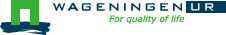

# A Jupyter notebook demonstrating how to run multiple simulations with PCSE/WOFOST

This Jupyter notebook will demonstrate how to implement a loop that can run multiple simulations using PCSE/WOFOST for water-limited conditions. Results are exported to an Excel file.

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;


## Importing the relevant modules

First the required modules need to be imported. These include the CGMS8 data providers for PCSE as well as other relevant modules.

**Important:** The variable `base_folder` must be changed to the location of your folder with input files.

In [1]:
from os import listdir
from os.path import join
import yaml
from pcse.fileinput import CABOFileReader
from pcse.models import Wofost71_WLP_FD
from pcse.base_classes import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.exceptions import WeatherDataProviderError
from pcse.util import WOFOST71SiteDataProvider
import pandas as pd
base_folder = r"D:\UserData\sources\pcse\notebooks\run_files"

## Setting up the parameters for crop, soil and site

Parameter files for crop and soil were taken from the [WOFOST Control Centre](http://www.wageningenur.nl/en/Expertise-Services/Research-Institutes/alterra/Facilities-Products/Software-and-models/WOFOST/Downloads.htm). These parameter file are in the `CABO` format which can be read the with `CABOFileReader` module.
### Crop parameter files

In [5]:
crop_dir = join(base_folder, 'crop')
crop_files = [CABOFileReader(join(crop_dir,f)) for f in listdir(crop_dir)]

### Soil parameter files

In [3]:
soil_dir = join(base_folder, 'soil')
soil_files = [CABOFileReader(join(soil_dir,f)) for f in listdir(soil_dir)]


### Site parameters
Site parameters are an ancillary class of parameters that are related to a given site. For example, an important parameter is the initial amount of moisture in the soil profile (`WAV`) and the atmospheric CO2 concentration.

In [6]:
sited = WOFOST71SiteDataProvider(WAV=100, CO2=360.)

## Agromanagement
Agromanagement can be defined in a file but often it is easier to define it directly as a string in the YAML format. Because the agromanagement needs to be updated for each year. It can thus be manipulated by string replacement and then parsed by the yaml parser. 

Here we define three agromanagement scenarios which define a crop calendar (no state or timed events) with suitable sowing dates for maize, potato and sugar beet in the Netherlands.

In [7]:
agro_maize = """
- {year}-03-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: 'maize'
        crop_start_date: {year}-04-15
        crop_start_type: sowing
        crop_end_date:
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- {year}-12-01: null
"""

agro_potato = """
- {year}-03-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: 'potato'
        crop_start_date: {year}-05-01
        crop_start_type: sowing
        crop_end_date:
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- {year}-12-01: null
"""

agro_sugarbeet = """
- {year}-03-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: 'sugar_beet'
        crop_start_date: {year}-05-01
        crop_start_type: sowing
        crop_end_date: {year}-10-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- {year}-12-01: null
"""
agro_templates = [agro_maize, agro_potato, agro_sugarbeet]

## Daily weather data

Weather data will be derived from the NASA POWER database which provides weather data at a resolution of 1x1 degree.

Note that since 2000, the POWER database has quite some missing rainfall records that will cause missing data in the WeatherDataProvider. PCSE makes no attempt to substitute weather data and therefore simulating these years will give problem because of a missing data. 

In [8]:
weatherdata = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(weatherdata)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER Agroclimatology Daily Averaged Data
Dates (month/day/year): 01/01/1984 through 03/07/2018
Location: Latitude 52   Longitude 5
Location clarification: Integer values may indicate the lower left (south and west) corner of the one degree lat/lon region that includes the requested locations
Elevation (meters): Average for one degree lat/lon region = 5
Methodology Documentation:
*Vegetation type: "Airport": flat rough grass
----Site characteristics----
Elevation:    5.0
Latitude:  52.000
Longitude:  5.000
Data available for 1997-01-01 - 2015-10-31
Number of missing days: 53



### Exporting weather data
Weather data can also be easily exported to a dataframe for further analysis.

In [10]:
df = pd.DataFrame(weatherdata.export()).set_index("DAY")
df.head()

,E0,ELEV,ES0,ET0,IRRAD,LAT,LON,RAIN,TEMP,TMAX,TMIN,VAP,WIND
DAY,,,,,,,,,,,,,
1997-01-01,0.002742,5.0,0.000000,0.034727,3740000.0,52.0,5.0,0.000,-10.18,-7.58,-12.21,1.967116,3.218101
1997-01-02,0.000000,5.0,0.000000,0.022778,3850000.0,52.0,5.0,0.000,-10.44,-5.99,-13.40,1.971998,1.846098
1997-01-03,0.035876,5.0,0.032665,0.051278,2840000.0,52.0,5.0,0.060,-7.78,-4.98,-11.46,2.452291,5.531111
1997-01-04,0.076629,5.0,0.075063,0.078899,1190000.0,52.0,5.0,0.031,-5.37,-2.89,-7.20,2.937416,5.408995
1997-01-05,0.000000,5.0,0.000000,0.013189,3850000.0,52.0,5.0,0.000,-5.90,-3.63,-8.41,3.150735,1.953847


## Simulating with WOFOST

### Implementing the main loop
The following example implements a loop running over all years, crops and soil types. Daily output for each run is converted to a Pandas DataFrame and written as a separate excel file to an output folder. Summary results from all simulations is written to a separate excel file at the end of the simulation.

In [24]:
# Placeholder for storing summary results
summary_results = []

# Years to simulate
years = range(1997, 1998)

# Loop over crops, soils and years
for cropd, agro in zip(crop_files, agro_templates):
    crop_type = cropd['CRPNAM']
    for soild in soil_files:
        soil_type = soild['SOLNAM']
        for year in years:
            # String to identify this run
            run_id = "{crop}_{soil}_{year}".format(crop=crop_type, soil=soil_type, year=year)
            
            # Set the agromanagement with correct year and crop
            agromanagement = yaml.load(agro.format(year=year, crop=crop_type))
            
            # Encapsulate parameters
            parameters = ParameterProvider(sitedata=sited, soildata=soild, cropdata=cropd)
            
            # Start WOFOST, run the simulation 
            try:
                wofost = Wofost71_WLP_FD(parameters, weatherdata, agromanagement)
                wofost.run_till_terminate()
            except WeatherDataProviderError as e:
                msg = "Runid '%s' failed because of missing weather data." % run_id
                print(msg)
                continue

            # convert daily output to Pandas DataFrame and store it
            df = pd.DataFrame(wofost.get_output()).set_index("day")
            fname = join(base_folder, "output", run_id + ".xls")
            df.to_excel(fname)
            
            # Collect summary results
            r = wofost.get_summary_output()[0]
            r['run_id'] = run_id
            summary_results.append(r)



### Looking at the summary results
The summary results output provides a concise overview of the results of all simulations. If you are interested only in the final simulation results it is often more convenient to use the summary results. Moreover, some output (such as the date of anthesis - `DOA`) that is provided in the summary results cannot be easily gathered from the daily output.

In [25]:
# Write the summary results to an excel file
df_summary = pd.DataFrame(summary_results).set_index('run_id')
fname = join(base_folder, "output", "summary_results.xls")
df_summary.to_excel(fname)
df_summary.head()

,CTRAT,DOA,DOE,DOH,DOM,DOS,DOV,DVS,LAIMAX,RD,TAGP,TWLV,TWRT,TWSO,TWST
run_id,,,,,,,,,,,,,,,
"Grain maize 201, N-Germany, Luxembourg_EC1-coarse_1997",24.844061,1997-07-21,1997-05-09,None,1997-09-23,1997-04-15,None,2.000688,4.900104,100.0,17901.637011,3269.475715,1739.991446,6901.788683,7730.372613
"Grain maize 201, N-Germany, Luxembourg_EC2-medium_1997",31.346632,1997-07-21,1997-05-09,None,1997-09-23,1997-04-15,None,2.000688,4.900104,100.0,21985.065699,3269.475715,1739.991446,10985.217371,7730.372613
"Grain maize 201, N-Germany, Luxembourg_EC3-medium fine_1997",31.346632,1997-07-21,1997-05-09,None,1997-09-23,1997-04-15,None,2.000688,4.900104,100.0,21985.065699,3269.475715,1739.991446,10985.217371,7730.372613
"Grain maize 201, N-Germany, Luxembourg_EC3-medium fine_1997",31.346632,1997-07-21,1997-05-09,None,1997-09-23,1997-04-15,None,2.000688,4.900104,100.0,21985.065699,3269.475715,1739.991446,10985.217371,7730.372613
"Potato 701, N-EC_EC1-coarse_1997",22.181592,1997-06-03,1997-05-19,None,1997-09-05,1997-05-01,None,2.002400,4.613584,50.0,12591.288461,1930.532772,799.836687,9099.939818,1560.815871


### Looking at the daily results
The excel files with the results from the batch simulation in the output folder should look like the figure below. Each excel file provides the results from a combination of crop, soil type and year: 
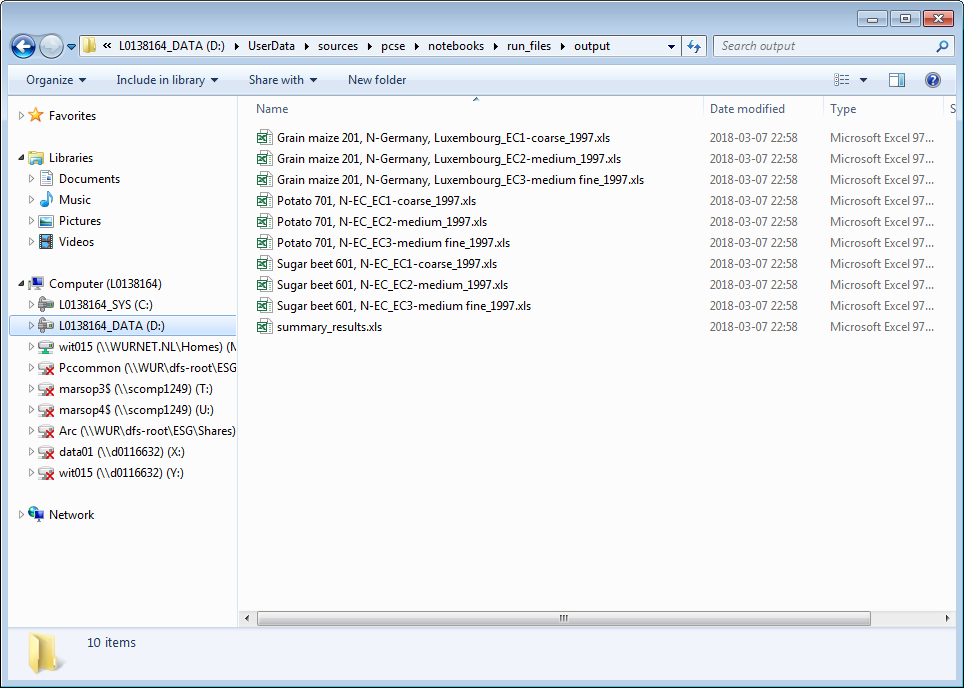